In [1]:
import numpy as np
import torch
from comet_ml import Experiment,ExistingExperiment
from comet_ml.integration.pytorch import log_model
import yaml
import h5py
import matplotlib.pyplot as plt

/Users/matthiasvigl/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
from Finetune_hep.python import train,helpers,models

In [3]:
device = helpers.get_device()
data_config_Xbb = 'config/ParT_Xbb_config.yaml'
data_config_latent = 'config/ParT_latent_config.yaml'
data_config_latent_hlf = 'config/ParT_latent_hlf_config.yaml'
data_config_Xbb_hlf = 'config/ParT_Xbb_hlf_config.yaml'

In [4]:
model_latent_hlf_head = models.head_model(data_config_Xbb_hlf,for_inference=True) 

In [5]:
'phi.0.weight' in model_latent_hlf_head.state_dict().keys()

True

In [6]:
model_Xbb = models.full_model(data_config_Xbb,for_inference=True)  
model_latent = models.full_model(data_config_latent,for_inference=False)  
model_Xbb_hlf = models.full_model(data_config_Xbb_hlf,for_inference=True,save_representaions=True)  
model_latent_hlf = models.full_model(data_config_latent_hlf,for_inference=True,save_representaions=True)  

In [7]:
model_latent_hlf

ParticleTransformerWrapper(
  (head): InvariantModel(
    (phi): Sequential(
      (0): Linear(in_features=133, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): ReLU()
    )
    (rho): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): ReLU()
      (6): Linear(in_features=128, out_features=1, bias=True)
      (7): Sigmoid()
    )
  )
  (mod): ParticleTransformer(
    (trimmer): SequenceTrimmer()
    (embed): Embed(
      (input_bn): BatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (embed): Sequential(
        (0): LayerNorm((17,), eps=1e-05, elementwise_affine=True)
        (1): Linear(in_features=17,

In [8]:
model_Xbb_hlf

ParticleTransformerWrapper(
  (Xbb): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
  )
  (head): InvariantModel(
    (phi): Sequential(
      (0): Linear(in_features=6, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): ReLU()
    )
    (rho): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): ReLU()
      (6): Linear(in_features=128, out_features=1, bias=True)
      (7): Sigmoid()
    )
  )
  (mod): ParticleTransformer(
    (trimmer): SequenceTrimmer()
    (embed): Embed(
      (input_bn): BatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (embed): Sequential(
        (0): Layer

In [9]:
model_latent

ParticleTransformerWrapper(
  (head): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
  (mod): ParticleTransformer(
    (trimmer): SequenceTrimmer()
    (embed): Embed(
      (input_bn): BatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (embed): Sequential(
        (0): LayerNorm((17,), eps=1e-05, elementwise_affine=True)
        (1): Linear(in_features=17, out_features=128, bias=True)
        (2): GELU(approximate='none')
        (3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (4): Linear(in_features=128, out_features=512, bias=True)
        (5): GELU(approximate='none')
        (6): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (7): Linear(in_features=512, 

In [10]:
model_Xbb.Task

'Xbb'

In [11]:
with h5py.File('../data/Data_val_sig_30.h5', 'r') as sample_sig:
    data = {}
    print(sample_sig.keys())
    print(sample_sig['X_jet'])
    print(sample_sig['X_jet_singlejet'])
    print(sample_sig['X_pfo_singlejet'])
    data['X_jet'] = sample_sig['X_jet'][:]
    data['X_pfo'] = sample_sig['X_pfo'][:]
    data['labels'] = sample_sig['labels'][:]
    data['jet_mask'] = sample_sig['jet_mask'][:]
    inputs = helpers.build_features_and_labels(data)
    data_Xbb = {}
    data_Xbb['X_jet'] = sample_sig['X_jet_singlejet'][:]
    data_Xbb['X_pfo'] = sample_sig['X_pfo_singlejet'][:]
    data_Xbb['labels'] = sample_sig['X_label_singlejet'][:]
    inputs_Xbb = helpers.build_features_and_labels_Xbb(data_Xbb)
with h5py.File('../data/Data_val_bkg_100.h5', 'r') as sample_bkg:
    data_bkg = {}
    print(sample_bkg.keys())
    print(sample_bkg['X_jet'])
    print(sample_bkg['X_jet_singlejet'])
    print(sample_bkg['X_pfo_singlejet'])
    data_bkg['X_jet'] = sample_bkg['X_jet'][:100]
    data_bkg['X_pfo'] = sample_bkg['X_pfo'][:100]
    data_bkg['labels'] = sample_bkg['labels'][:100]
    data_bkg['jet_mask'] = sample_bkg['jet_mask'][:100]
    inputs_bkg = helpers.build_features_and_labels(data_bkg)
    data_Xbb_bkg = {}
    data_Xbb_bkg['X_jet'] = sample_bkg['X_jet_singlejet'][:100]
    data_Xbb_bkg['X_pfo'] = sample_bkg['X_pfo_singlejet'][:100]
    data_Xbb_bkg['labels'] = sample_bkg['X_label_singlejet'][:100]
    inputs_Xbb_bkg = helpers.build_features_and_labels_Xbb(data_Xbb_bkg)    


<KeysViewHDF5 ['X_jet', 'X_jet_singlejet', 'X_label', 'X_label_singlejet', 'X_pfo', 'X_pfo_singlejet', 'jet_mask', 'labels']>
<HDF5 dataset "X_jet": shape (26, 5, 6), type "<f8">
<HDF5 dataset "X_jet_singlejet": shape (60, 6), type "<f8">
<HDF5 dataset "X_pfo_singlejet": shape (60, 100, 15), type "<f8">
<KeysViewHDF5 ['X_jet', 'X_jet_singlejet', 'X_label', 'X_label_singlejet', 'X_pfo', 'X_pfo_singlejet', 'jet_mask', 'labels']>
<HDF5 dataset "X_jet": shape (3536, 5, 6), type "<f8">
<HDF5 dataset "X_jet_singlejet": shape (7975, 6), type "<f8">
<HDF5 dataset "X_pfo_singlejet": shape (7975, 100, 15), type "<f8">


/Users/matthiasvigl/Documents/Physics/EndToEnd/public/Finetune_hep/python/helpers.py:72: RuntimeWarning: divide by zero encountered in log
  result = np.log(ma_data)


In [12]:
inputs.keys()

dict_keys(['pf_points', 'pf_features', 'pf_vectors', 'pf_mask', 'jet_mask', 'label', 'hl_feats'])

In [13]:
pf_points = torch.tensor(inputs['pf_points']).float().to(device)
pf_features = torch.tensor(inputs['pf_features']).float().to(device)
pf_vectors = torch.tensor(inputs['pf_vectors']).float().to(device)
pf_mask = torch.tensor(inputs['pf_mask']).float().to(device)
hl_feats = torch.tensor(inputs['hl_feats']).float().to(device)
jet_mask = torch.tensor(inputs['jet_mask']).float().to(device)

preds = model_latent(pf_points,pf_features,pf_vectors,pf_mask,jet_mask,hl_feats)

/Users/matthiasvigl/Library/Python/3.9/lib/python/site-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [14]:
preds.shape

torch.Size([26, 1])

In [15]:
pf_points = torch.tensor(inputs_Xbb['pf_points']).float().to(device)
pf_features = torch.tensor(inputs_Xbb['pf_features']).float().to(device)
pf_vectors = torch.tensor(inputs_Xbb['pf_vectors']).float().to(device)
pf_mask = torch.tensor(inputs_Xbb['pf_mask']).float().to(device)

pf_points_bkg = torch.tensor(inputs_Xbb_bkg['pf_points']).float().to(device)
pf_features_bkg = torch.tensor(inputs_Xbb_bkg['pf_features']).float().to(device)
pf_vectors_bkg = torch.tensor(inputs_Xbb_bkg['pf_vectors']).float().to(device)
pf_mask_bkg = torch.tensor(inputs_Xbb_bkg['pf_mask']).float().to(device)

preds_Xbb = model_Xbb(pf_points,pf_features,pf_vectors,pf_mask)

In [16]:
preds_Xbb.shape

torch.Size([60, 1])

In [17]:
idxmap = helpers.get_idxmap('config/train.txt')
idxmap_val = helpers.get_idxmap('config/val.txt')
integer_file_map = helpers.create_integer_file_map(idxmap)
integer_file_map_val = helpers.create_integer_file_map(idxmap_val)

In [18]:
model_Xbb.load_state_dict(torch.load('/Users/matthiasvigl/Xbb_lr0.01_bs512_subset0.1.pt',map_location=torch.device(device)))

<All keys matched successfully>

In [19]:
model_latent = helpers.load_weights(model_latent,'/Users/matthiasvigl/Xbb_lr0.01_bs512_subset0.1.pt',device)
model_latent_hlf = helpers.load_weights(model_latent_hlf,'/Users/matthiasvigl/Xbb_lr0.01_bs512_subset0.1.pt',device)
model_Xbb_hlf = helpers.load_weights(model_Xbb_hlf,'/Users/matthiasvigl/Xbb_lr0.01_bs512_subset0.1.pt',device)
model_Xbb = helpers.load_weights(model_Xbb,'/Users/matthiasvigl/Xbb_lr0.01_bs512_subset0.1.pt',device)

loading weights :
dict_keys(['mod.cls_token', 'mod.embed.input_bn.weight', 'mod.embed.input_bn.bias', 'mod.embed.input_bn.running_mean', 'mod.embed.input_bn.running_var', 'mod.embed.input_bn.num_batches_tracked', 'mod.embed.embed.0.weight', 'mod.embed.embed.0.bias', 'mod.embed.embed.1.weight', 'mod.embed.embed.1.bias', 'mod.embed.embed.3.weight', 'mod.embed.embed.3.bias', 'mod.embed.embed.4.weight', 'mod.embed.embed.4.bias', 'mod.embed.embed.6.weight', 'mod.embed.embed.6.bias', 'mod.embed.embed.7.weight', 'mod.embed.embed.7.bias', 'mod.pair_embed.embed.0.weight', 'mod.pair_embed.embed.0.bias', 'mod.pair_embed.embed.0.running_mean', 'mod.pair_embed.embed.0.running_var', 'mod.pair_embed.embed.0.num_batches_tracked', 'mod.pair_embed.embed.1.weight', 'mod.pair_embed.embed.1.bias', 'mod.pair_embed.embed.2.weight', 'mod.pair_embed.embed.2.bias', 'mod.pair_embed.embed.2.running_mean', 'mod.pair_embed.embed.2.running_var', 'mod.pair_embed.embed.2.num_batches_tracked', 'mod.pair_embed.embed.4.w

In [20]:
with torch.no_grad():
    model_Xbb.eval()
    preds_Xbb = model_Xbb(pf_points,pf_features,pf_vectors,pf_mask)
    preds_Xbb_bkg = model_Xbb(pf_points_bkg,pf_features_bkg,pf_vectors_bkg,pf_mask_bkg)

[]

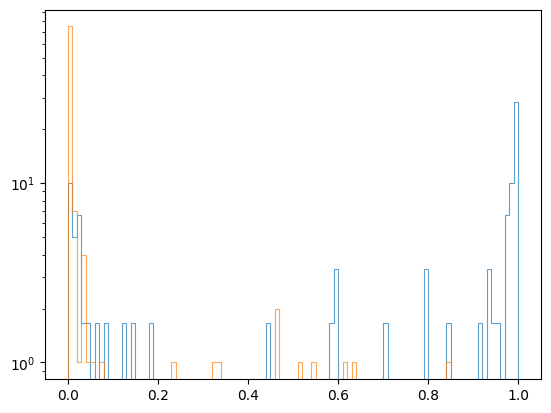

In [21]:
b=np.linspace(0,1,101)
fig, ax = plt.subplots()
ax.hist(preds_Xbb.detach().numpy(), lw=0.8,bins=b,histtype='step', density=True, alpha=0.7)
ax.hist(preds_Xbb_bkg.detach().numpy(), lw=0.8,bins=b,histtype='step', density=True, alpha=0.7)
ax.semilogy()

In [22]:
with h5py.File('/Users/matthiasvigl/Data_test_bkg_100.h5', 'r') as sample:
    Xbb_scores = {}
    Xbb_scores['Xbb_score'] = sample['Xbb_score'][:]
    Xbb_scores['Xbb_label'] = sample['Xbb_label'][:]


In [23]:
np.max(Xbb_scores['Xbb_label'][:])

0

In [24]:
Xbb_scores['Xbb_score'].shape

(35359, 5, 1)

[]

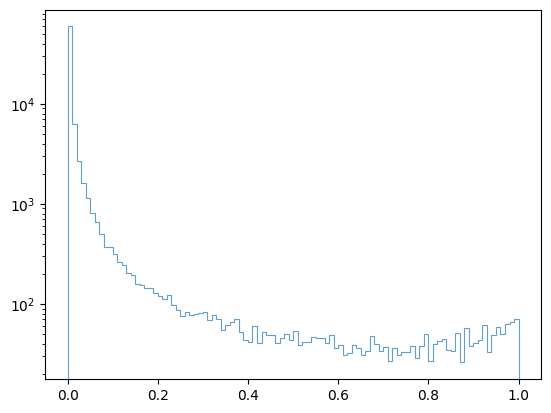

In [25]:

b=np.linspace(0,1,101)
fig, ax = plt.subplots()
ax.hist(Xbb_scores['Xbb_score'][:].reshape(-1), lw=0.8,bins=b,histtype='step', density=False, alpha=0.7)
ax.semilogy()

In [26]:
import os
import h5py
from sklearn.metrics import roc_curve

def get_sccores(directory):
    scores ={}
    files = os.listdir(directory)
    h5_files = [file for file in files if file.endswith('.h5')]
    i=0
    for h5_file in h5_files:
        with h5py.File(os.path.join(directory, h5_file), 'r') as f:
            if i==0:
                scores["score"] = f['evt_score'][:]
                scores["label"] = f['evt_label'][:]
            else:
                scores["score"] = np.concatenate((scores["score"],f['evt_score'][:]),axis=0)
                scores["label"] = np.concatenate((scores["label"],f['evt_label'][:]),axis=0)
        i+=1        
    return scores            

In [28]:
Finetuned_Xbb_hl = get_sccores('/Users/matthiasvigl/Finetuned_Xbb_hl/scores')
fpr_Finetuned, tpr_Finetuned, thresholds_Finetuned = roc_curve(Finetuned_Xbb_hl['label'],Finetuned_Xbb_hl['score'])
Scratch_Xbb_hl = get_sccores('/Users/matthiasvigl/Scratch_Xbb_hl/scores')
fpr_Scratch, tpr_Scratch, thresholds_Scratch = roc_curve(Scratch_Xbb_hl['label'],Scratch_Xbb_hl['score'])
Frozen_Xbb_hl = get_sccores('/Users/matthiasvigl/Frozen_Xbb_hl/scores')
fpr_Frozen, tpr_Frozen, thresholds_Frozen = roc_curve(Frozen_Xbb_hl['label'],Frozen_Xbb_hl['score'])
tpr_common = np.linspace(0,1,1001)
fpr_Frozen = np.interp(tpr_common,tpr_Frozen,fpr_Frozen)
fpr_Scratch = np.interp(tpr_common,tpr_Scratch,fpr_Scratch)
fpr_Finetuned = np.interp(tpr_common,tpr_Finetuned,fpr_Finetuned)

/var/folders/8y/gdfl1n5n1xg6phgtfzx9t4340000gn/T/ipykernel_94785/539660676.py:2: RuntimeWarning: divide by zero encountered in divide
  ax.plot(tpr_common,1/fpr_Finetuned,label='Finetune')
/var/folders/8y/gdfl1n5n1xg6phgtfzx9t4340000gn/T/ipykernel_94785/539660676.py:3: RuntimeWarning: divide by zero encountered in divide
  ax.plot(tpr_common,1/fpr_Scratch,label='Scratch')
/var/folders/8y/gdfl1n5n1xg6phgtfzx9t4340000gn/T/ipykernel_94785/539660676.py:4: RuntimeWarning: divide by zero encountered in divide
  ax.plot(tpr_common,1/fpr_Frozen,label='Frozen')
/var/folders/8y/gdfl1n5n1xg6phgtfzx9t4340000gn/T/ipykernel_94785/539660676.py:9: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(tpr_common,fpr_Frozen/fpr_Finetuned,label='Finetune')
/var/folders/8y/gdfl1n5n1xg6phgtfzx9t4340000gn/T/ipykernel_94785/539660676.py:9: RuntimeWarning: invalid value encountered in divide
  ax2.plot(tpr_common,fpr_Frozen/fpr_Finetuned,label='Finetune')
/var/folders/8y/gdfl1n5n1xg6phgtfzx9t4340000

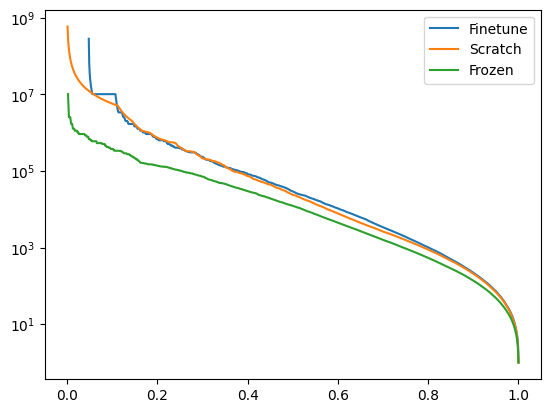

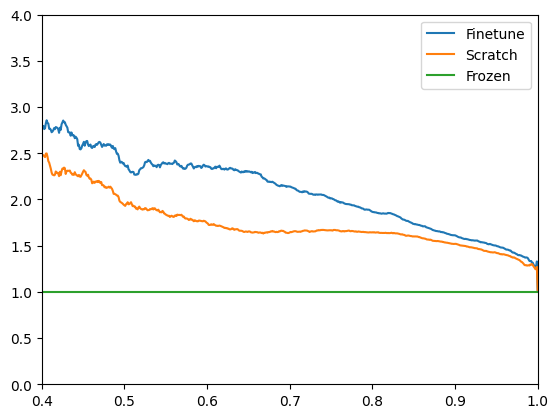

In [29]:
fig, ax = plt.subplots()
ax.plot(tpr_common,1/fpr_Finetuned,label='Finetune')
ax.plot(tpr_common,1/fpr_Scratch,label='Scratch')
ax.plot(tpr_common,1/fpr_Frozen,label='Frozen')
ax.legend()
ax.semilogy()

fig2, ax2 = plt.subplots()
ax2.plot(tpr_common,fpr_Frozen/fpr_Finetuned,label='Finetune')
ax2.plot(tpr_common,fpr_Frozen/fpr_Scratch,label='Scratch')
ax2.plot(tpr_common,fpr_Frozen/fpr_Frozen,label='Frozen')
ax2.set_ylim(0,4)
ax2.set_xlim(0.4,1)
ax2.legend()

[]

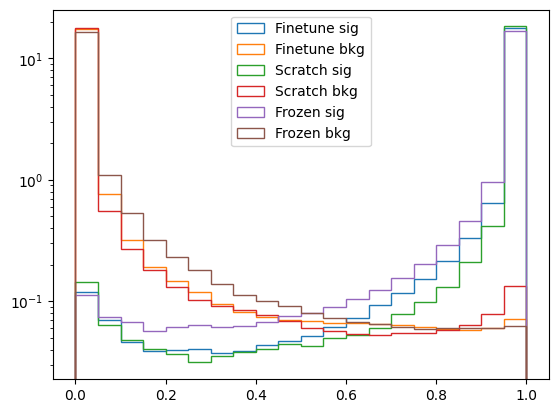

In [30]:
b=np.linspace(0,1,21)
fig, ax = plt.subplots()
ax.hist(Finetuned_Xbb_hl['score'],bins=b,weights=Finetuned_Xbb_hl['label'],histtype='step',density=True,label='Finetune sig')
ax.hist(Finetuned_Xbb_hl['score'],bins=b,weights=1*(Finetuned_Xbb_hl['label']==0),histtype='step',density=True,label='Finetune bkg')
ax.hist(Scratch_Xbb_hl['score'],bins=b,weights=Scratch_Xbb_hl['label'],histtype='step',density=True,label='Scratch sig')
ax.hist(Scratch_Xbb_hl['score'],bins=b,weights=1*(Scratch_Xbb_hl['label']==0),histtype='step',density=True,label='Scratch bkg')
ax.hist(Frozen_Xbb_hl['score'],bins=b,weights=Frozen_Xbb_hl['label'],histtype='step',density=True,label='Frozen sig')
ax.hist(Frozen_Xbb_hl['score'],bins=b,weights=1*(Frozen_Xbb_hl['label']==0),histtype='step',density=True,label='Frozen bkg')
ax.legend()
ax.semilogy()